In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

cuda


# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
#DATA_SET = 'Circles'
DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

torch.Size([160, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 538 ms, sys: 166 ms, total: 704 ms
Wall time: 600 ms


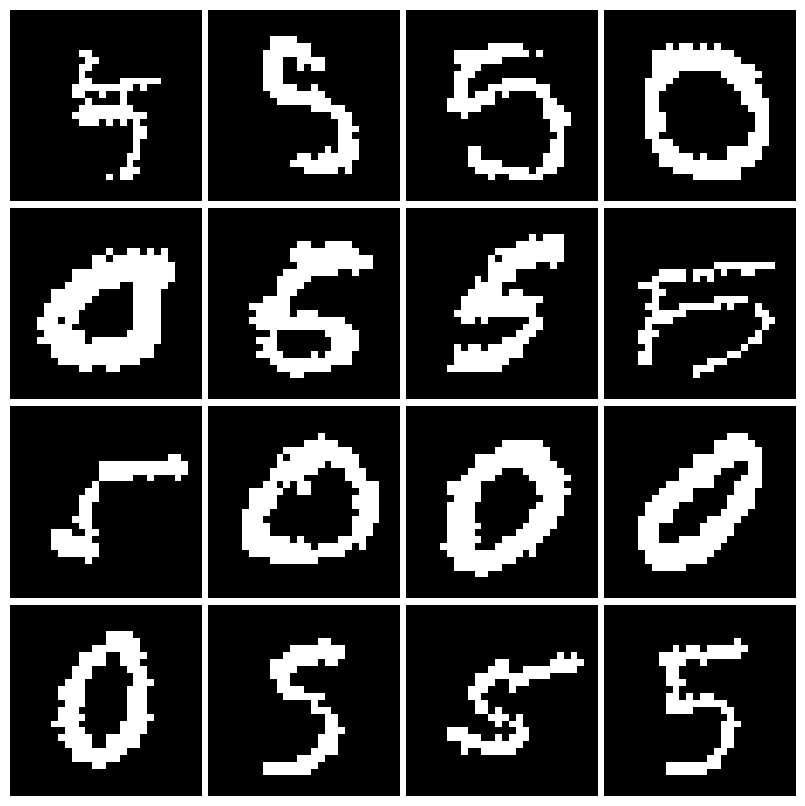

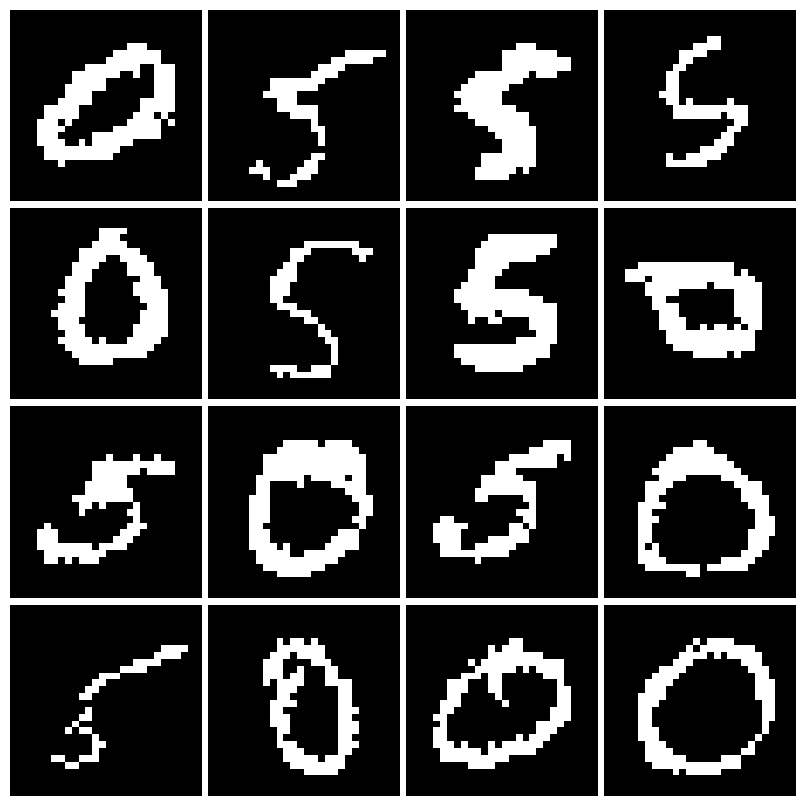

In [4]:
%%time

if DATA_SET == 'Circles' :
    shapes, targets = gen_circles_dataset(num_images=200, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

train_dataset = torch.bernoulli(train_dataset)
eval_dataset = torch.bernoulli(eval_dataset)

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([160, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.1506) tensor(0.3577)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.1591) tensor(0.3658)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 74 µs, sys: 24 µs, total: 98 µs
Wall time: 99.9 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=200,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

callbacks = []
history_cb = TrainHistoryCallback()
callbacks.append(history_cb)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-10_14-24-34. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 200
 - per_device_train_batch_size: 160
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f3aa0f2fc40>

Successfully launched training !



Training of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 569.013
Eval loss: 517.4004
--------------------------------------------------------------------------


Training of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 524.2218
Eval loss: 488.6944
--------------------------------------------------------------------------


Training of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 487.1741
Eval loss: 450.559
--------------------------------------------------------------------------


Training of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 451.6961
Eval loss: 420.1636
--------------------------------------------------------------------------


Training of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 414.2864
Eval loss: 384.6149
--------------------------------------------------------------------------


Training of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 377.1388
Eval loss: 360.8366
--------------------------------------------------------------------------


Training of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 355.4182
Eval loss: 331.0843
--------------------------------------------------------------------------


Training of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 325.3492
Eval loss: 315.3618
--------------------------------------------------------------------------


Training of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 318.3994
Eval loss: 294.5872
--------------------------------------------------------------------------


Training of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 306.2153
Eval loss: 292.1939
--------------------------------------------------------------------------


Training of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 285.9295
Eval loss: 277.7668
--------------------------------------------------------------------------


Training of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 270.2527
Eval loss: 275.7488
--------------------------------------------------------------------------


Training of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 268.609
Eval loss: 271.758
--------------------------------------------------------------------------


Training of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 265.5862
Eval loss: 262.1699
--------------------------------------------------------------------------


Training of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 267.6092
Eval loss: 267.3198
--------------------------------------------------------------------------


Training of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 256.4001
Eval loss: 260.3587
--------------------------------------------------------------------------


Training of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 249.7214
Eval loss: 256.4713
--------------------------------------------------------------------------


Training of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 247.4342
Eval loss: 253.1152
--------------------------------------------------------------------------


Training of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 243.8138
Eval loss: 247.4699
--------------------------------------------------------------------------


Training of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 241.4785
Eval loss: 241.8545
--------------------------------------------------------------------------


Training of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 237.29
Eval loss: 241.7969
--------------------------------------------------------------------------


Training of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 234.8694
Eval loss: 244.0921
--------------------------------------------------------------------------


Training of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 232.0813
Eval loss: 239.8577
--------------------------------------------------------------------------


Training of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 231.1594
Eval loss: 234.3583
--------------------------------------------------------------------------


Training of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 228.2182
Eval loss: 233.102
--------------------------------------------------------------------------


Training of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 225.4479
Eval loss: 235.7881
--------------------------------------------------------------------------


Training of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 224.0885
Eval loss: 231.6658
--------------------------------------------------------------------------


Training of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 221.9901
Eval loss: 229.2472
--------------------------------------------------------------------------


Training of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 220.9934
Eval loss: 231.7287
--------------------------------------------------------------------------


Training of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 218.0227
Eval loss: 224.5676
--------------------------------------------------------------------------


Training of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 216.899
Eval loss: 225.0535
--------------------------------------------------------------------------


Training of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 216.1158
Eval loss: 223.6301
--------------------------------------------------------------------------


Training of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 213.9408
Eval loss: 221.603
--------------------------------------------------------------------------


Training of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 213.0576
Eval loss: 223.8571
--------------------------------------------------------------------------


Training of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.7182
Eval loss: 220.7956
--------------------------------------------------------------------------


Training of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 209.0938
Eval loss: 219.5791
--------------------------------------------------------------------------


Training of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.6593
Eval loss: 214.9057
--------------------------------------------------------------------------


Training of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 206.1177
Eval loss: 213.7322
--------------------------------------------------------------------------


Training of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 204.6448
Eval loss: 214.021
--------------------------------------------------------------------------


Training of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 203.7833
Eval loss: 211.372
--------------------------------------------------------------------------


Training of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.3818
Eval loss: 210.2655
--------------------------------------------------------------------------


Training of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 200.2072
Eval loss: 208.2861
--------------------------------------------------------------------------


Training of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.8489
Eval loss: 207.031
--------------------------------------------------------------------------


Training of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.8601
Eval loss: 207.3906
--------------------------------------------------------------------------


Training of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.0706
Eval loss: 205.073
--------------------------------------------------------------------------


Training of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.1233
Eval loss: 204.095
--------------------------------------------------------------------------


Training of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.9576
Eval loss: 205.2166
--------------------------------------------------------------------------


Training of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.8021
Eval loss: 202.6809
--------------------------------------------------------------------------


Training of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.706
Eval loss: 205.0574
--------------------------------------------------------------------------


Training of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.6681
Eval loss: 205.7594
--------------------------------------------------------------------------


Training of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 192.0784
Eval loss: 202.0415
--------------------------------------------------------------------------


Training of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 191.7344
Eval loss: 202.9787
--------------------------------------------------------------------------


Training of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.8311
Eval loss: 202.0577
--------------------------------------------------------------------------


Training of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.338
Eval loss: 202.8495
--------------------------------------------------------------------------


Training of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.1753
Eval loss: 201.9394
--------------------------------------------------------------------------


Training of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 189.1458
Eval loss: 200.6191
--------------------------------------------------------------------------


Training of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.053
Eval loss: 199.5297
--------------------------------------------------------------------------


Training of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.0511
Eval loss: 201.8251
--------------------------------------------------------------------------


Training of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.1631
Eval loss: 198.6733
--------------------------------------------------------------------------


Training of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 186.9424
Eval loss: 198.0165
--------------------------------------------------------------------------


Training of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.603
Eval loss: 197.3471
--------------------------------------------------------------------------


Training of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.9258
Eval loss: 197.7516
--------------------------------------------------------------------------


Training of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.3199
Eval loss: 196.5972
--------------------------------------------------------------------------


Training of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.4989
Eval loss: 197.5976
--------------------------------------------------------------------------


Training of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 184.0368
Eval loss: 196.4297
--------------------------------------------------------------------------


Training of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.5356
Eval loss: 195.9996
--------------------------------------------------------------------------


Training of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 183.3576
Eval loss: 195.9751
--------------------------------------------------------------------------


Training of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.8515
Eval loss: 195.7956
--------------------------------------------------------------------------


Training of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.6855
Eval loss: 194.9477
--------------------------------------------------------------------------


Training of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.4713
Eval loss: 195.3079
--------------------------------------------------------------------------


Training of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.0198
Eval loss: 195.1705
--------------------------------------------------------------------------


Training of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.8981
Eval loss: 195.1343
--------------------------------------------------------------------------


Training of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.3085
Eval loss: 195.4116
--------------------------------------------------------------------------


Training of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.0122
Eval loss: 194.9321
--------------------------------------------------------------------------


Training of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.6458
Eval loss: 194.5717
--------------------------------------------------------------------------


Training of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.3859
Eval loss: 193.7922
--------------------------------------------------------------------------


Training of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.9014
Eval loss: 193.7468
--------------------------------------------------------------------------


Training of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.9692
Eval loss: 193.4634
--------------------------------------------------------------------------


Training of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.6059
Eval loss: 193.6039
--------------------------------------------------------------------------


Training of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.368
Eval loss: 194.1794
--------------------------------------------------------------------------


Training of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.1672
Eval loss: 194.1293
--------------------------------------------------------------------------


Training of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.5894
Eval loss: 192.613
--------------------------------------------------------------------------


Training of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 178.2786
Eval loss: 192.9417
--------------------------------------------------------------------------


Training of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.7966
Eval loss: 194.3386
--------------------------------------------------------------------------


Training of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.8397
Eval loss: 193.9033
--------------------------------------------------------------------------


Training of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.5244
Eval loss: 192.5968
--------------------------------------------------------------------------


Training of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 177.3433
Eval loss: 194.4309
--------------------------------------------------------------------------


Training of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.8617
Eval loss: 193.4831
--------------------------------------------------------------------------


Training of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.2596
Eval loss: 193.0784
--------------------------------------------------------------------------


Training of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.2087
Eval loss: 194.3127
--------------------------------------------------------------------------


Training of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.7838
Eval loss: 192.9407
--------------------------------------------------------------------------


Training of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.5537
Eval loss: 191.9554
--------------------------------------------------------------------------


Training of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.0463
Eval loss: 192.2633
--------------------------------------------------------------------------


Training of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 175.3885
Eval loss: 191.8803
--------------------------------------------------------------------------


Training of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.8417
Eval loss: 191.6977
--------------------------------------------------------------------------


Training of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.3223
Eval loss: 191.9502
--------------------------------------------------------------------------


Training of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.3199
Eval loss: 191.8899
--------------------------------------------------------------------------


Training of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.0571
Eval loss: 191.9408
--------------------------------------------------------------------------


Training of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.7515
Eval loss: 191.9676
--------------------------------------------------------------------------


Training of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.5563
Eval loss: 191.7616
--------------------------------------------------------------------------


Training of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.7351
Eval loss: 192.1302
--------------------------------------------------------------------------


Training of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6562
Eval loss: 193.5873
--------------------------------------------------------------------------


Training of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.5409
Eval loss: 191.7936
--------------------------------------------------------------------------


Training of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.3109
Eval loss: 190.943
--------------------------------------------------------------------------


Training of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.141
Eval loss: 191.972
--------------------------------------------------------------------------


Training of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 171.8142
Eval loss: 191.9845
--------------------------------------------------------------------------


Training of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 171.4881
Eval loss: 190.967
--------------------------------------------------------------------------


Training of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 171.3499
Eval loss: 192.4738
--------------------------------------------------------------------------


Training of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 171.4343
Eval loss: 190.9826
--------------------------------------------------------------------------


Training of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.9051
Eval loss: 191.3062
--------------------------------------------------------------------------


Training of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.5426
Eval loss: 190.968
--------------------------------------------------------------------------


Training of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.6143
Eval loss: 192.3746
--------------------------------------------------------------------------


Training of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.1827
Eval loss: 190.6548
--------------------------------------------------------------------------


Training of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.1509
Eval loss: 191.6416
--------------------------------------------------------------------------


Training of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.4206
Eval loss: 192.057
--------------------------------------------------------------------------


Training of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.2366
Eval loss: 190.4751
--------------------------------------------------------------------------


Training of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.0226
Eval loss: 190.8076
--------------------------------------------------------------------------


Training of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.6306
Eval loss: 190.6812
--------------------------------------------------------------------------


Training of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.7269
Eval loss: 190.8329
--------------------------------------------------------------------------


Training of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.1953
Eval loss: 190.0299
--------------------------------------------------------------------------


Training of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.1893
Eval loss: 190.5472
--------------------------------------------------------------------------


Training of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.1725
Eval loss: 188.8742
--------------------------------------------------------------------------


Training of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 167.7607
Eval loss: 190.1251
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 167.7886
Eval loss: 189.7617
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 167.2846
Eval loss: 191.0699
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 167.1747
Eval loss: 189.0881
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.9503
Eval loss: 189.0539
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.7515
Eval loss: 190.2449
--------------------------------------------------------------------------


Training of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.52
Eval loss: 190.1907
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.4881
Eval loss: 189.2895
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.0
Eval loss: 189.952
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.9692
Eval loss: 189.0124
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.8917
Eval loss: 189.0
--------------------------------------------------------------------------


Epoch 00133: reducing learning rate of group 0 to 5.0000e-04.


Training of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.5895
Eval loss: 189.4872
--------------------------------------------------------------------------


Training of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.7559
Eval loss: 188.8776
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.4652
Eval loss: 188.0049
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.2601
Eval loss: 188.598
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.0811
Eval loss: 189.0324
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.2502
Eval loss: 187.8248
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.2516
Eval loss: 188.6912
--------------------------------------------------------------------------


Training of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.2481
Eval loss: 188.9643
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.839
Eval loss: 187.6932
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.6729
Eval loss: 187.9677
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.5687
Eval loss: 188.0325
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.6425
Eval loss: 187.673
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.5994
Eval loss: 188.1047
--------------------------------------------------------------------------


Training of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.5763
Eval loss: 188.3772
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.4441
Eval loss: 188.0736
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.2821
Eval loss: 188.7122
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.172
Eval loss: 188.4784
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.173
Eval loss: 188.2123
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.1423
Eval loss: 187.2222
--------------------------------------------------------------------------


Training of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.8372
Eval loss: 187.4095
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.9988
Eval loss: 188.0316
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.9771
Eval loss: 189.0257
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.6639
Eval loss: 187.6054
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.6994
Eval loss: 187.6673
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.5728
Eval loss: 187.8342
--------------------------------------------------------------------------


Training of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.5879
Eval loss: 187.1115
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.0092
Eval loss: 187.7944
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.4101
Eval loss: 188.1164
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.248
Eval loss: 188.3994
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.1196
Eval loss: 188.2371
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.0519
Eval loss: 188.0436
--------------------------------------------------------------------------


Training of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.8888
Eval loss: 187.2749
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.0001
Eval loss: 187.6125
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.9206
Eval loss: 187.0732
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.5791
Eval loss: 187.417
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.7776
Eval loss: 186.5049
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.8855
Eval loss: 187.6371
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.5276
Eval loss: 186.8953
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.5601
Eval loss: 187.6462
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.2742
Eval loss: 187.1169
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.1958
Eval loss: 187.0275
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.2278
Eval loss: 187.3267
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.0385
Eval loss: 187.2525
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.034
Eval loss: 188.5538
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.8707
Eval loss: 187.2417
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.2129
Eval loss: 187.3952
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 162.0427
Eval loss: 186.3874
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.6552
Eval loss: 187.1183
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.6389
Eval loss: 186.631
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.7211
Eval loss: 188.1324
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.6479
Eval loss: 186.4059
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.6675
Eval loss: 187.6262
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.6232
Eval loss: 186.9027
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.1903
Eval loss: 187.0388
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.3365
Eval loss: 185.6608
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.2641
Eval loss: 187.3085
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.273
Eval loss: 186.6789
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.2704
Eval loss: 186.0797
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.2154
Eval loss: 186.3036
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.1305
Eval loss: 186.0923
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.2415
Eval loss: 185.8309
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.9567
Eval loss: 186.0193
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.7915
Eval loss: 187.0871
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.7745
Eval loss: 185.8809
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.7379
Eval loss: 186.7225
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.7762
Eval loss: 186.0363
--------------------------------------------------------------------------


Epoch 00199: reducing learning rate of group 0 to 2.5000e-04.


Training of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 160.6151
Eval loss: 186.8316
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-06-10_14-24-34/final_model


CPU times: user 37.5 s, sys: 1.02 s, total: 38.6 s
Wall time: 40.2 s


## Loss History

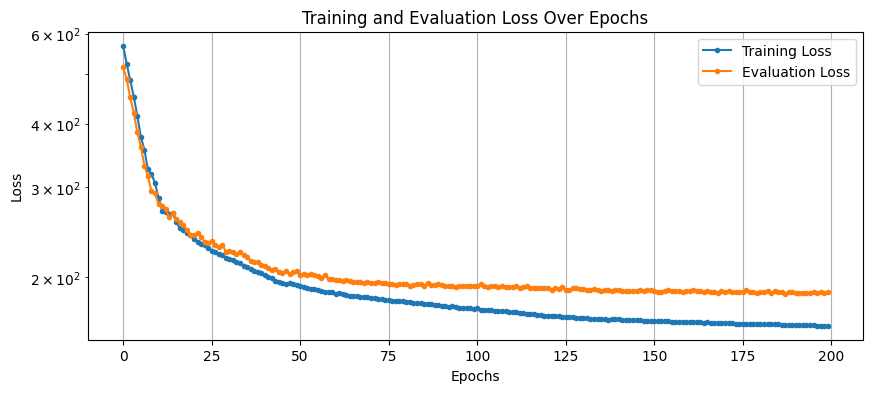

In [12]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(history_cb.history['train_loss'], label='Training Loss', marker='.')
plt.plot(history_cb.history['eval_loss'], label='Evaluation Loss', marker='.')

# Add titles and labels
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Trained Model

In [13]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

In [14]:
# latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(latents[:, 0], latents[:, 1], c=eval_labels, cmap='viridis', marker='o')
# legend = plt.legend(*scatter.legend_elements(), title="Classes")


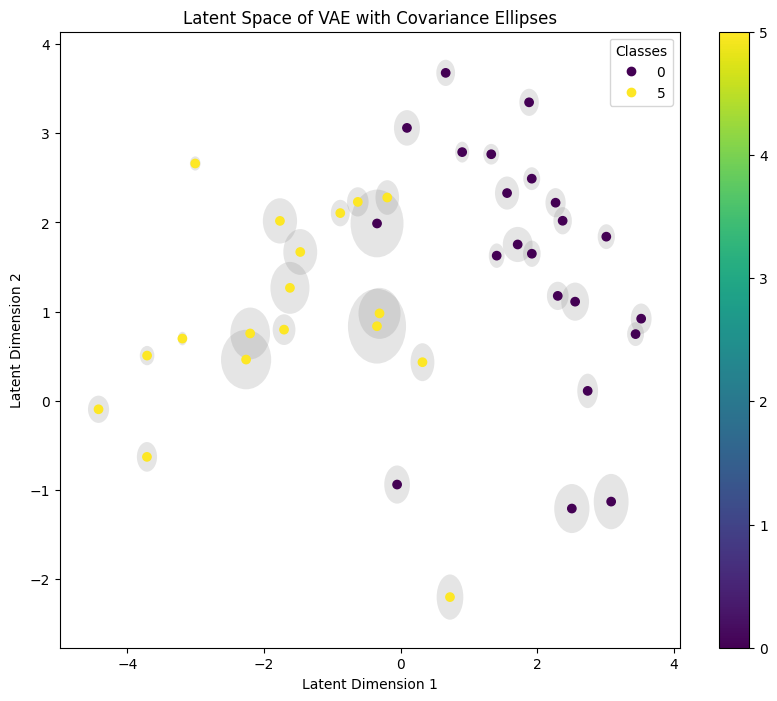

In [15]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=1)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

In [16]:
trained_model.metric

Metric_MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (diag): Linear(in_features=400, out_features=2, bias=True)
  (lower): Linear(in_features=400, out_features=1, bias=True)
)

In [17]:
trained_model
# 'centroids',
 # 'centroids_tens', 
 # 'metric', 
 # 'G',
 # 'G_inv',
 # 'M',
 # 'M_tens',
 # 'T_destination',

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)

# RECONSTRUCTIONS

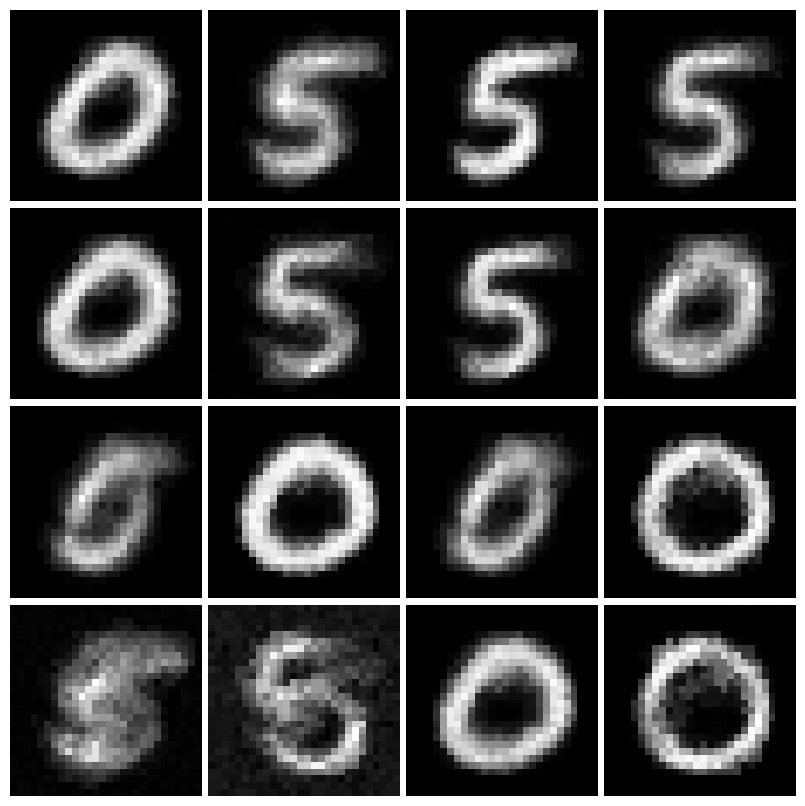

In [18]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

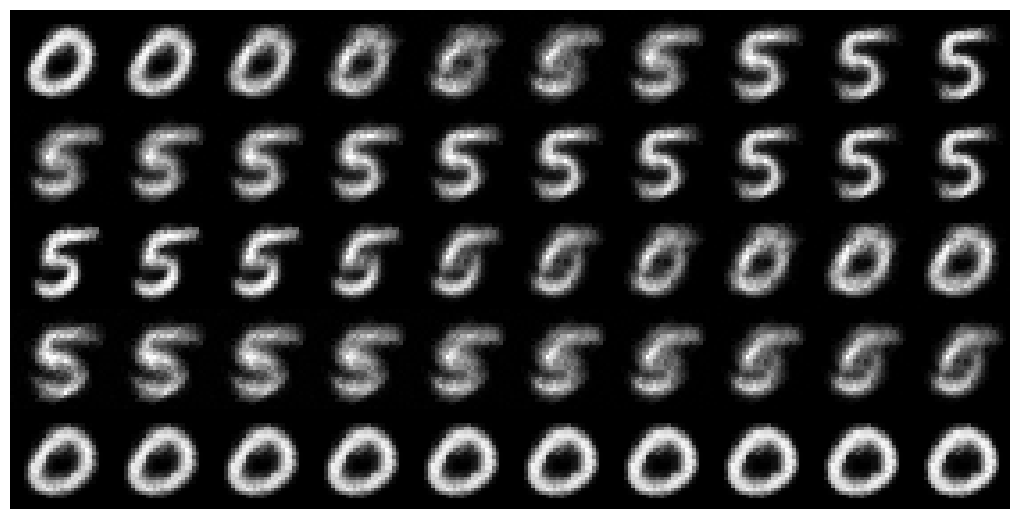

In [19]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [20]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [21]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 2.0078
IS [mean] = 1.5140
IS [std] = 0.3348


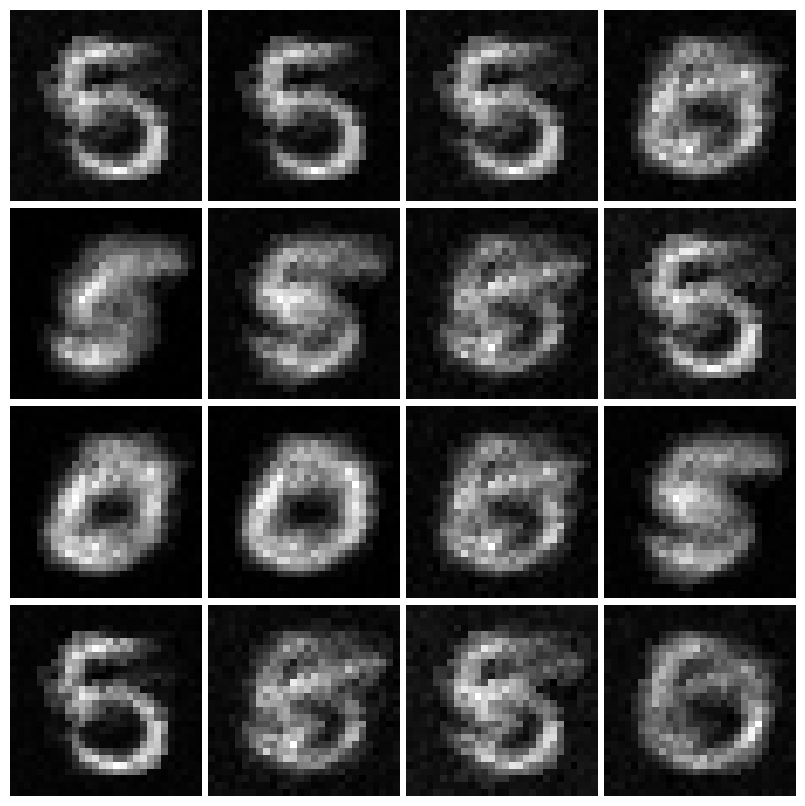

In [22]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [23]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 1.2246
IS [mean] = 2.0685
IS [std] = 0.4188


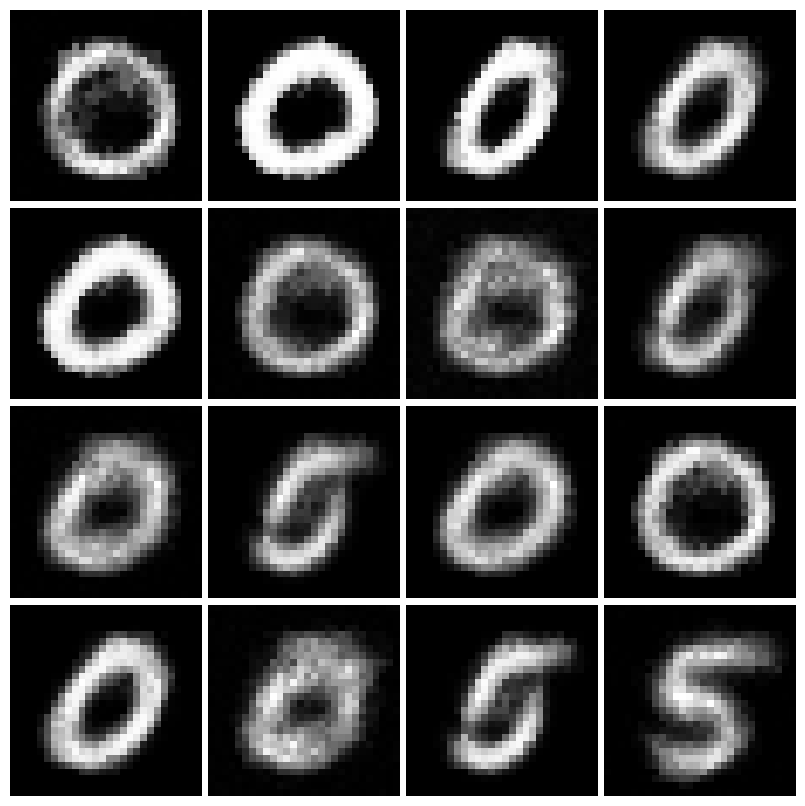

In [24]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [25]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 15,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 0.9807
IS [mean] = 1.9361
IS [std] = 0.1451


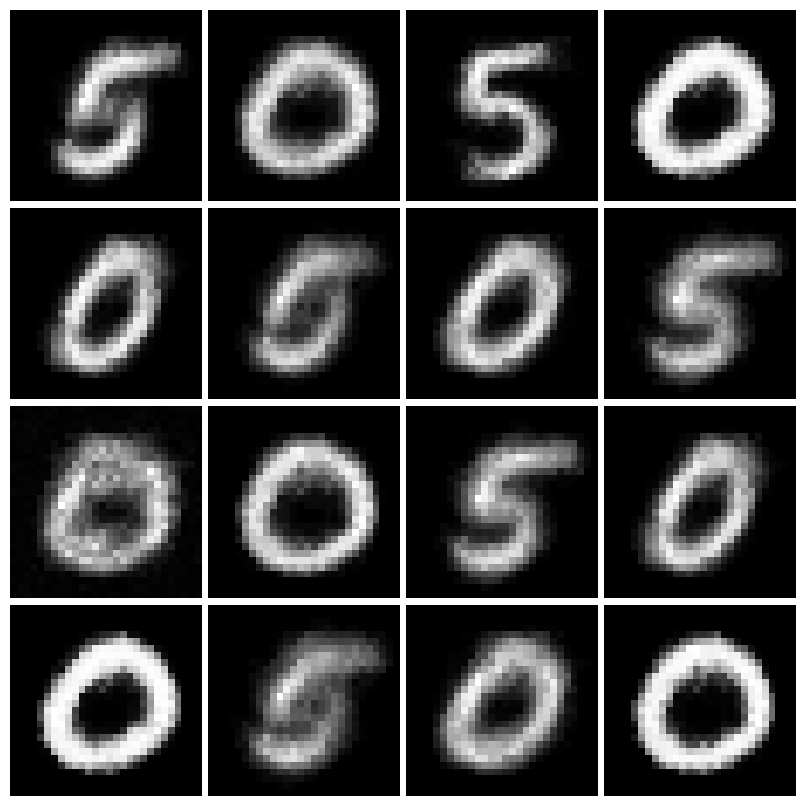

In [26]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)